In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This tutorial shows how to train a Keras model on tabular data and get feature attributions on your trained model.

### Dataset

The dataset used for this tutorial was created by combining two BigQuery Public Datasets: [London Bikeshare data](https://console.cloud.google.com/marketplace/details/greater-london-authority/london-bicycles?filter=solution-type%3Adataset&q=london%20bicycle%20hires&id=95374cac-2834-4fa2-a71f-fc033ccb5ce4) and [NOAA weather data](https://console.cloud.google.com/marketplace/details/noaa-public/gsod?filter=solution-type:dataset&q=noaa&id=c6c1b652-3958-4a47-9e58-552a546df47f). 

### Objective

In this notebook, you will learn how to use AI Explanations with an tabular model you trained. The purpose of this tutorial is to demonstrate how to explain your model locally using the Explainable AI SDK, without having to deploy to AI Platform. The steps performed include: 

* Train a Keras model.
* Get explanations locally in the AI Platform Notebooks environment
* \[Optional\] Deploy the model to AI Platform.

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* AI Platform Prediction, only if you decide to deploy the model

Learn about [Cloud AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin
This notebook is intended to run on [AI Platform Notebooks](https://cloud.google.com/ai-platform-notebooks) since it contains necessary dependencies including (but not limited to) [Explainable AI SDK](https://github.com/GoogleCloudPlatform/explainable_ai_sdk).

### Import libraries and define constants

In [1]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import json
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import explainable_ai_sdk
from explainable_ai_sdk.metadata.tf.v1 import KerasGraphMetadataBuilder

# Should be 1.15.X
print(tf.__version__)

1.15.3-dlenv_tfe


## Downloading and preprocessing data

In this section you'll download the data to train your model from a public GCS bucket. The original data is from the BigQuery datasets linked above. For your convenience, we've joined the London bike and NOAA weather tables, done some preprocessing, and provided a subset of that dataset here.

In [2]:
# Copy the data to your notebook instance
!gsutil cp 'gs://explanations_sample_data/bike-data.csv' ./

Copying gs://explanations_sample_data/bike-data.csv...
| [1 files][265.3 MiB/265.3 MiB]                                                
Operation completed over 1 objects/265.3 MiB.                                    


In [3]:
data = pd.read_csv('bike-data.csv')

# Shuffle the data
data = data.sample(frac=1, random_state=2)

# Drop rows with null values
data = data[data['wdsp'] != 999.9]
data = data[data['dewp'] != 9999.9]

# Rename some columns for readability
data=data.rename(columns = {'day_of_week':'weekday'})
data=data.rename(columns = {'max':'max_temp'})
data=data.rename(columns = {'dewp': 'dew_point'})

# Drop columns we won't use to train this model
data = data.drop(columns=['start_station_name', 'end_station_name', 'bike_id', 'snow_ice_pellets'])

# Convert trip duration from seconds to minutes so it's easier to understand
data['duration'] = data['duration'].apply(lambda x:float(x / 60))

In [4]:
# Preview the first 5 rows
data.head()

,start_hr,weekday,euclidean,temp,dew_point,wdsp,max_temp,fog,prcp,rain_drizzle,duration
1559391,21,4,582.724880,54.7,46.2,0.0,56.3,0,0.00,0,22.0
1881386,16,2,2358.922742,57.1,48.2,0.0,64.9,0,0.00,0,12.0
703461,23,1,766.066253,69.2,51.6,0.0,80.4,0,0.00,0,12.0
1688076,9,5,2271.877229,52.5,45.4,0.0,63.3,0,0.02,0,13.0
2079007,14,7,2476.718116,50.3,43.5,0.0,56.1,0,0.01,0,28.0


In [5]:
# Save duration to its own DataFrame and remove it from the original DataFrame
labels = data['duration']
data = data.drop(columns=['duration'])

### Split data into train and test sets

We'll split our data into train and test sets using an 80 / 20 train / test split.

In [6]:
# Use 80/20 train/test split
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

# Split our data into train and test sets
train_data = data[:train_size]
train_labels = labels[:train_size]

test_data = data[train_size:]
test_labels = labels[train_size:]

Train size: 757363
Test size: 189341


## Build the Model

Build a Keras model with 2 hidden layers.

In [ ]:
# Build our model
model = tf.keras.Sequential(name="bike_predict")
model.add(tf.keras.layers.Dense(64, input_dim=len(train_data.iloc[0]), activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [8]:
# Compile the model and see a summary
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
model.summary()

Model: "bike_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


### Create an input data pipeline with tf.data

In [9]:
batch_size = 256
epochs = 3

input_train = tf.data.Dataset.from_tensor_slices(train_data)
output_train = tf.data.Dataset.from_tensor_slices(train_labels)
input_train = input_train.batch(batch_size).repeat()
output_train = output_train.batch(batch_size).repeat()
train_dataset = tf.data.Dataset.zip((input_train, output_train))

### Train the model

In [10]:
# This will take about a minute to run
# To keep training time short, we're not using the full dataset
model.fit(train_dataset, steps_per_epoch=train_size // batch_size, epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2958 steps
Epoch 1/3
2958/2958 [==============================] - 17s 6ms/step - loss: 1.3011
Epoch 2/3
2958/2958 [==============================] - 16s 5ms/step - loss: 0.6141
Epoch 3/3
2958/2958 [==============================] - 16s 5ms/step - loss: 0.4411


In [11]:
# Run evaluation
results = model.evaluate(test_data, test_labels)
print(results)

189341/189341 [==============================] - 11s 56us/sample - loss: 0.3538
0.3537751135294457


## Get Explanations
In this section, you will explain the output of the model for input examples. The explanation workflow includes the following steps:

* Create an explanation metadata file to specify your model's inputs and outputs.
* Save the model with the metadata.
* Reload the model through [Explainable AI SDK](https://github.com/GoogleCloudPlatform/explainable_ai_sdk) with explanation parameters.
* Call `explain` function with an arbitrary input to get feature attributions.
* Use `visualize_attributions` function to visualize the model explanations.

Use `explainable_ai_sdk` to create an explanation metadata. Since this Keras model accepts a single tensor, you can actually specify what each dimension represent in this tensor via `index_feature_mapping` parameter to get attributions made to these features.

In [ ]:
md_builder = KerasGraphMetadataBuilder(model)
md_builder.set_numeric_metadata(model.inputs[0], index_feature_mapping=train_data.columns.tolist())

Save the model and the metadata into the same folder. `save_model_with_metadata` function prints signature definitions that it saved the model with.

In [ ]:
model_dir = 'bike_model'
md_builder.save_model_with_metadata(model_dir)

### Reload the Model through Explainable AI SDK
While reloading the model, you can specify which explanation technique to use. Non-image models can make use of *Integrated Gradients* and *Sampled Shapley* techniques. For this example, specify Sampled Shapley config. The only parameter it accepts is `path_count`, which specifies the number of paths it uses to approximate feature contributions.

In [14]:
lm = explainable_ai_sdk.load_model_from_local_path(
    model_dir,  # Model path containing explanation metadata JSON.
    explainable_ai_sdk.SampledShapleyConfig(path_count=20)
)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from bike_model/variables/variables


### Explain an Input
Choose an arbitrary example from training set. Note that you can provide a list of examples per `explain` call.

In [18]:
attributions = lm.explain([{'dense_input:0': test_data.iloc[0].values.tolist()}])

### Visualize Attributions
Call `visualize_attributions` to see a bar plot depicting how much each feature contributed to the prediction.

Label Index 0
Example Score: 17.7111
Baseline Score: -0.2139
Approximation Error: 0.0659


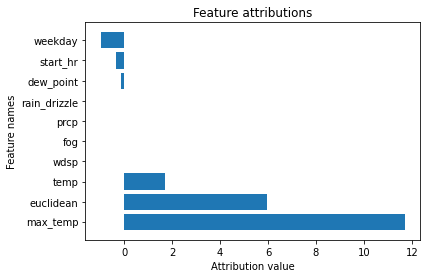

In [19]:
# Attributions contain an attribution per given example.
attributions[0].visualize_attributions()

### Explore Different Parameters
There are various parameters you can change. `path_count` in Sampled Shapley config, baselines, label indices are some of them. Use `params_override` in the `explain` call to change these parameters. Alternatively, you can create a new model instance with updated parameters.

Check out the [github repo](https://github.com/GoogleCloudPlatform/explainable_ai_sdk) for Explainable AI SDK for the API and parameters.

Label Index 0
Example Score: 17.7111
Baseline Score: -0.2139
Approximation Error: 0.0171


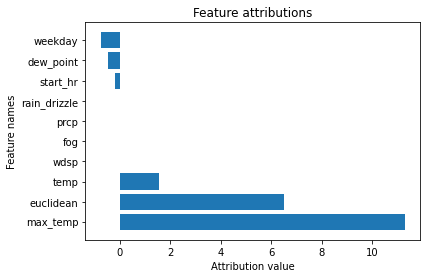

In [20]:
# Explaining with different path count
attributions = lm.explain(
    [{'dense_input:0': test_data.iloc[0].values.tolist()}],
    params=explainable_ai_sdk.AttributionParameters(
        attribution_config=explainable_ai_sdk.SampledShapleyConfig(path_count=50)))

# Observe the difference in Approximation Error.
attributions[0].visualize_attributions()

# [Optional] Deploy the Model to AI Platform
In this optional step, you will deploy the model to AI Platform to have a hosted solution to get model explanations.

In [21]:
PROJECT_ID = "your-project-id"  # Change to your project ID.

### Create the Model
**You only need to run this once.**

In [ ]:
MODEL = 'bike'
! gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

### Save the Model to GCS
You need to save the model to a GCS bucket to deploy to AI Platform.



#### Create a bucket
**You need to run this only once.**

Note that you can use an existing GCS bucket instead of running this gsutil command, which creates a new one.

In [23]:
BUCKET_NAME = PROJECT_ID + "_bike_model"  # Rename to your liking
REGION = "us-central1"

In [ ]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Call `save_model_with_metadata` function to save the model and the metadata to your bucket.

In [ ]:
model_gcs_path = "gs://" + BUCKET_NAME + "/model"
md_builder.save_model_with_metadata(model_gcs_path)

### Create a Model Version.

In [26]:
# Each time you create a version the name should be unique
MODEL_VERSION = 'ss_v1'

In [ ]:
# Create the version with gcloud
!gcloud beta ai-platform versions create $MODEL_VERSION \
--model $MODEL \
--origin $model_gcs_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method sampled-shapley \
--num-paths 20

In [ ]:
# Make sure the model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $MODEL_VERSION --model $MODEL

**Make sure that the state of the model is `READY` before moving on.**

## Explain an Input with the Deployed Model
Now, call the deployed model using `explainable_ai_sdk` to get attributions for an arbitary input example. First, create a remote model instance through `explainable_ai_sdk` providing project, model, and version parameters. Then, you can call the `explain` function to receive the explanations from the deployed model the same way you would from a local model above.

*Note: Deployed models don't support parameter overriding. Hence if you provide `params` in the `explain` call, it won't have any effect in the explanations.*

In [29]:
# Create the model
rm = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, MODEL_VERSION)

In [30]:
attributions = rm.explain([{'dense_input': test_data.iloc[0].values.tolist()}])

Label Index 0
Example Score: 17.7111
Baseline Score: -0.2139
Approximation Error: 0.0659


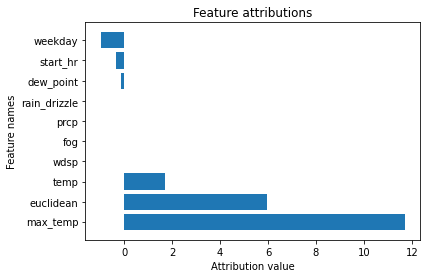

In [31]:
# Note the difference in visualization due to different visualization settings.
attributions[0].visualize_attributions()

# Cleaning up

*Run these steps only if you deployed a model to AI Platform. Otherwise, feel free to ignore.*

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.


In [ ]:
# Delete model version resource
# Note that if there are multiple model versions, you need to delete them
# one by one.
! gcloud ai-platform versions delete $MODEL_VERSION --quiet --model $MODEL

# Delete model resource
! gcloud ai-platform models delete $MODEL --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r gs://$BUCKET_NAME